Objetivo:

**¿Podemos predecir el costo del seguro medico de un cliente, basandonos en sus caracteristicas demograficas y de salud?

Tipo de problema: Regresion

In [1]:
#Importar librerias
import pandas as pd #manipulacion de data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Configuracion de Seaborn para Graficas
sns.set_style('whitegrid')

**Analisis Exploratorio**

In [2]:
#Importar el dataset
df= pd.read_csv('insurance.csv')

print(df.head())
print()
print('Numero de filas y columnas en el dataset',df.shape)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Numero de filas y columnas en el dataset (1338, 7)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Podemos observar que no hay datos nulos en este dataset

In [4]:
#Preparacion de datos para la correlacion
df_numeric= df.copy()

df_numeric['sex']= df_numeric['sex'].map({'female':0,'male':1})
df_numeric['smoker']= df_numeric['smoker'].map({'no':0, 'yes':1})

df_numeric = pd.get_dummies(df_numeric, columns=['region'])

<Axes: >

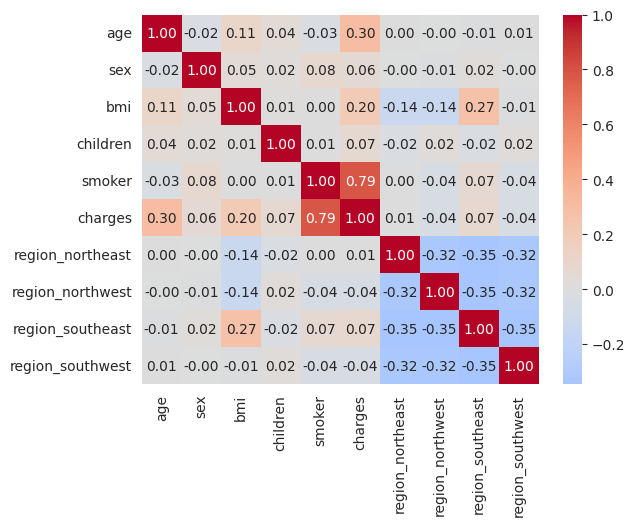

In [5]:
#Correlation plot 
corr= df_numeric.corr()
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    center=0)

se puede observar una correlaicon fuerte entre las variables smoker y charges

Es decir ser fumador incremeta en gran medida el costo de vida

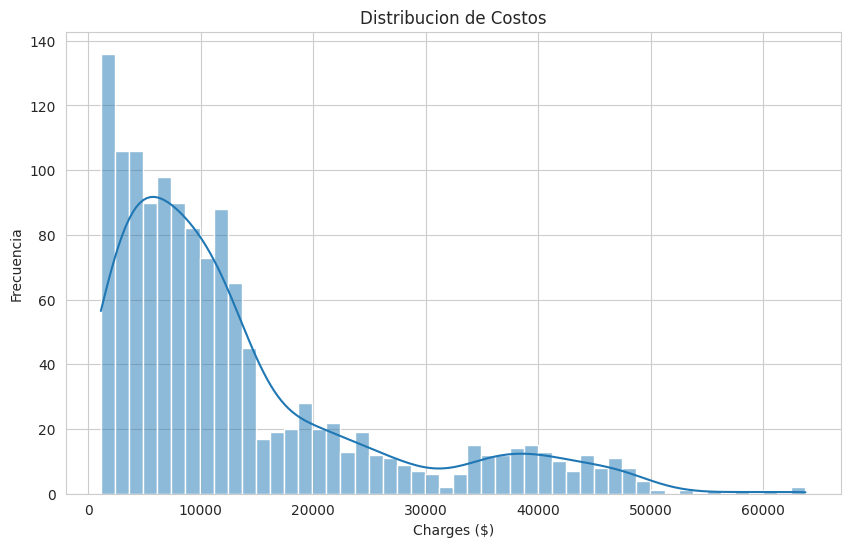

Descripccion estadistica: 
 count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


In [6]:
#Analisis de Charges (Variable objetivo)
plt.figure(figsize=(10,6))
sns.histplot(
    df['charges'],
    kde=True,
    bins=50)
plt.title('Distribucion de Costos')
plt.xlabel('Charges ($)')
plt.ylabel('Frecuencia')
plt.show()

print('Descripccion estadistica: \n',df['charges'].describe())


La distribucion de charges esta sesgada hacia la derecha, es decir la mayoria de las personas tienen costos bajos, pero hay un peuqñeo numero con costos altisimos.

Como un modelo de regresion lineal asume normalidad tenemso que transformar esta variable

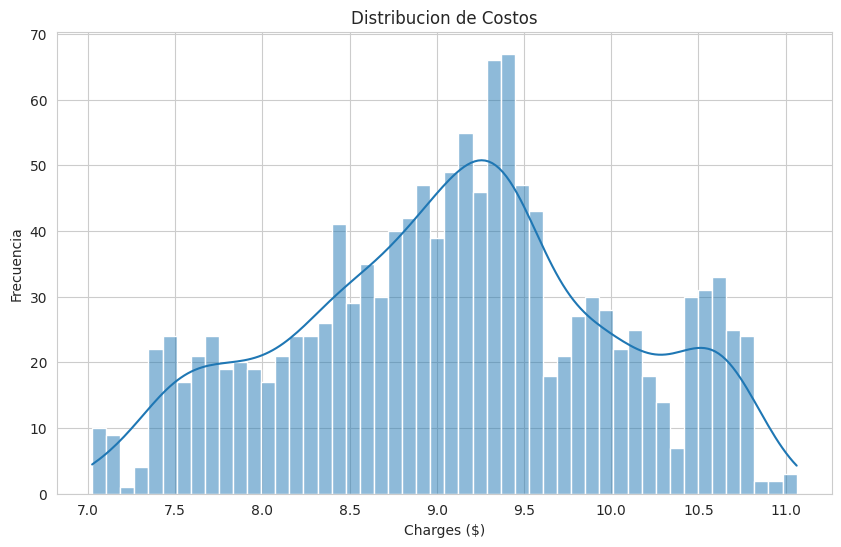

In [7]:
#Transformado la variable charges

df['charges'] = np.log1p(df['charges']) #usamos np.logip(log(1+x)) en caso de que existan ceros

plt.figure(figsize=(10,6))
sns.histplot(
    df['charges'],
    kde=True,
    bins=50)
plt.title('Distribucion de Costos')
plt.xlabel('Charges ($)')
plt.ylabel('Frecuencia')
plt.show()

Ahora analizaremos la variable smoker en el costo

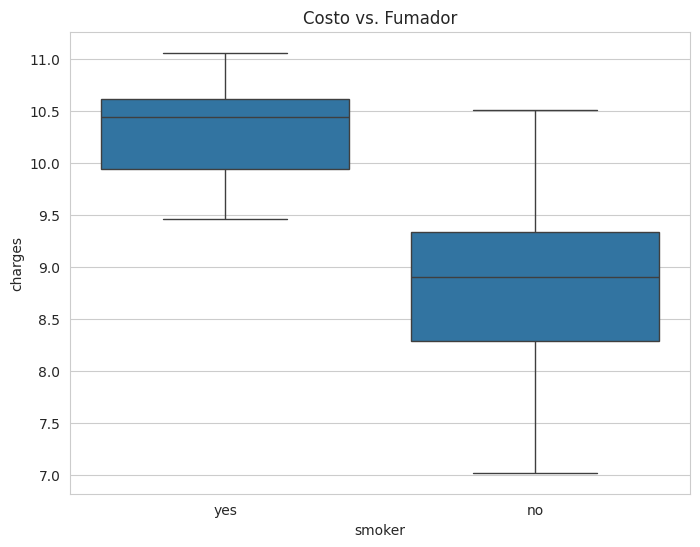

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='smoker', y='charges')
plt.title('Costo vs. Fumador')
plt.show()

Ser fumador incrementa el costo del seguro de forma significativa.

¿Sera que exista un impacto en la edad si la persona es fumadora?

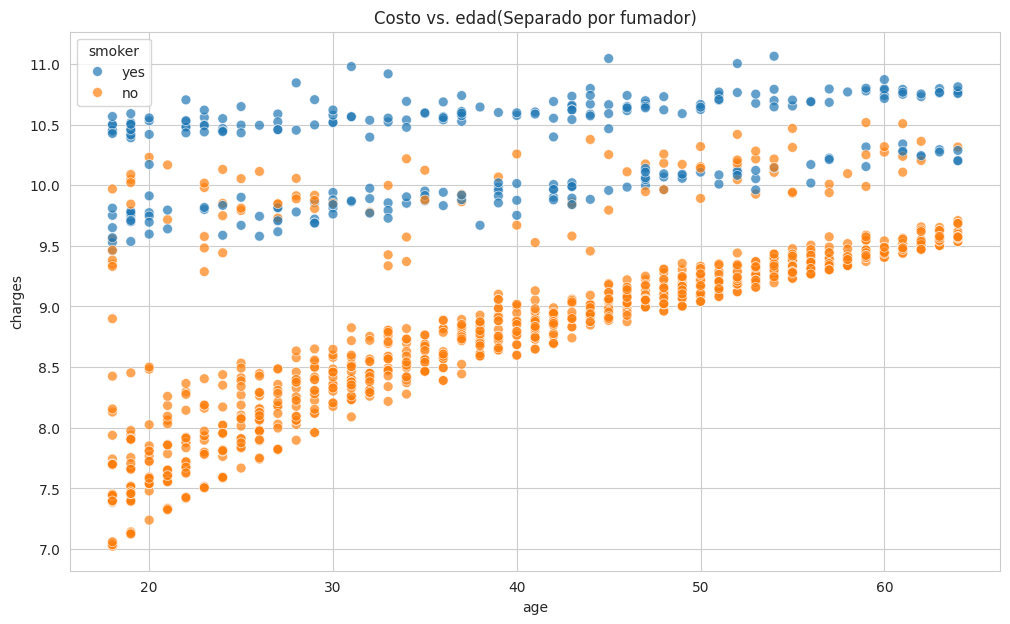

In [9]:
plt.figure(figsize=(12,7))
sns.scatterplot(
    data=df,
    x='age',
    y='charges',
    hue='smoker',
    alpha=0.7,
    s=50)
plt.title('Costo vs. edad(Separado por fumador)')
plt.show()

Para los no fumadores vemos que sus costos incrementan de forma lineal y lenta con la edad

Para los fumadores sus costos tambien aumentan con la edad pero desde un punto de partida mucho mas alto

¿Cual sera el impacto del IMC(bmi por sus siglas en ingles) y el fumar?

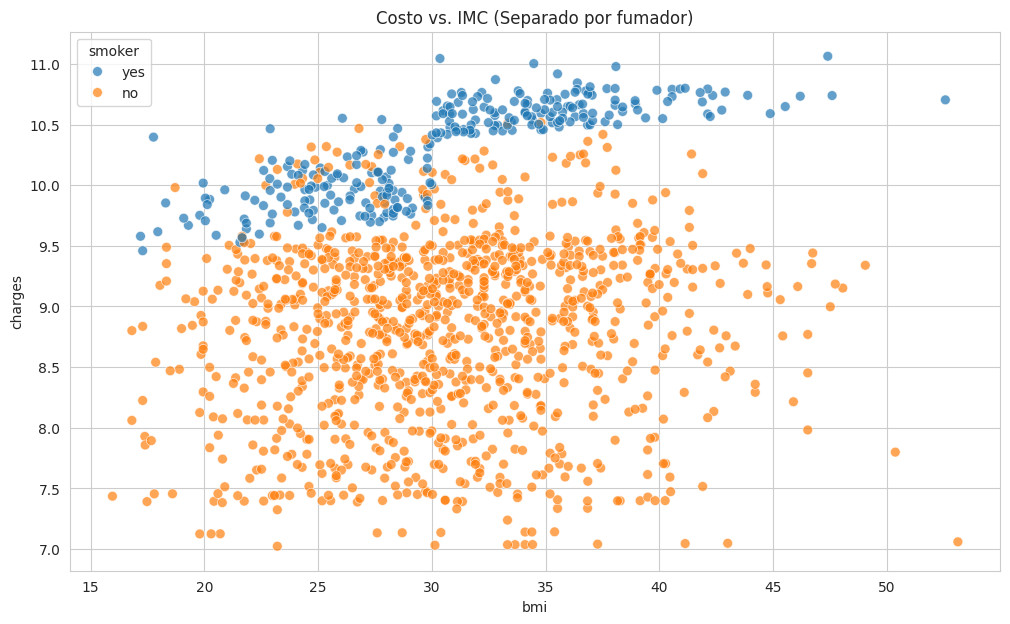

In [10]:
plt.figure(figsize=(12,7))
sns.scatterplot(
    data=df,
    x='bmi',
    y='charges',
    hue='smoker',
    alpha=0.7,
    s=50
)
plt.title('Costo vs. IMC (Separado por fumador)')
plt.show()

Notemos que para los no fumadores el IMC no parece tener un impacto realmente grande, sin embargo para los fumadores un IMC alto, en particular >30 hace que los costos suban.

**Modelo de Regresion Lineal**

In [11]:
#Importar librerias de Scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [12]:
#Definimos los features y target

df_processed=pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)

X=df_processed.drop('charges', axis=1)
y= df_processed['charges']

In [13]:
#Dividimos en entremaiento y prueba
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
#Escalar variables numericas

numeric_features=['age', 'bmi', 'children']
scaler=StandardScaler()

#Ajustamos el scaler para los datos de entrenamiento
X_train[numeric_features]= scaler.fit_transform(X_train[numeric_features])

#Transformamos los datos test con el scaler
X_test[numeric_features]= scaler.transform(X_test[numeric_features])

print(X_train.head())

           age       bmi  children  sex_male  smoker_yes  region_northwest  \
560   0.472227 -1.756525  0.734336     False       False              True   
1285  0.543313 -1.033082 -0.911192     False       False             False   
1142  0.898745 -0.943687 -0.911192     False       False             False   
969  -0.025379  0.622393  3.202629     False       False             False   
486   1.040918 -1.504893  1.557100     False       False              True   

      region_southeast  region_southwest  
560              False             False  
1285             False             False  
1142              True             False  
969               True             False  
486              False             False  


In [15]:
#Entrenamos el modelo
model=LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


**Evaluacion del Modelo**

In [16]:
#Predicciones
y_pred_log=model.predict(X_test)

In [17]:
#Revertimos la trasformacion log
y_pred= np.expm1(y_pred_log)
y_test_orig=np.expm1(y_test)

In [18]:
#Calculamos las metricas

r2= r2_score(y_test_orig,y_pred)
mae=mean_absolute_error(y_test_orig, y_pred)
rmse= np.sqrt(mean_squared_error(y_test_orig,y_pred))

print('--Resultados del Modelo de Regresion Lienal--')
print(f'R-cuadrado:{r2:.4f}')
print(f'Error Absoluto Medio(MAE):{mae:.2f}')
print(f'Error cuadratico medio raiz (RMSE):{rmse:.2f}')

--Resultados del Modelo de Regresion Lienal--
R-cuadrado:0.6067
Error Absoluto Medio(MAE):3888.44
Error cuadratico medio raiz (RMSE):7814.06


El modelo explica el 79% de la variabilidad en los costos del seguro

El error típico de mi modelo es de $3,888, el RMSE es significativamente más alto. Esto indica que el modelo es bastante preciso para la mayoría de los clientes, pero está cometiendo algunos errores muy grandes al intentar predecir los costos de los clientes más 'extremos'

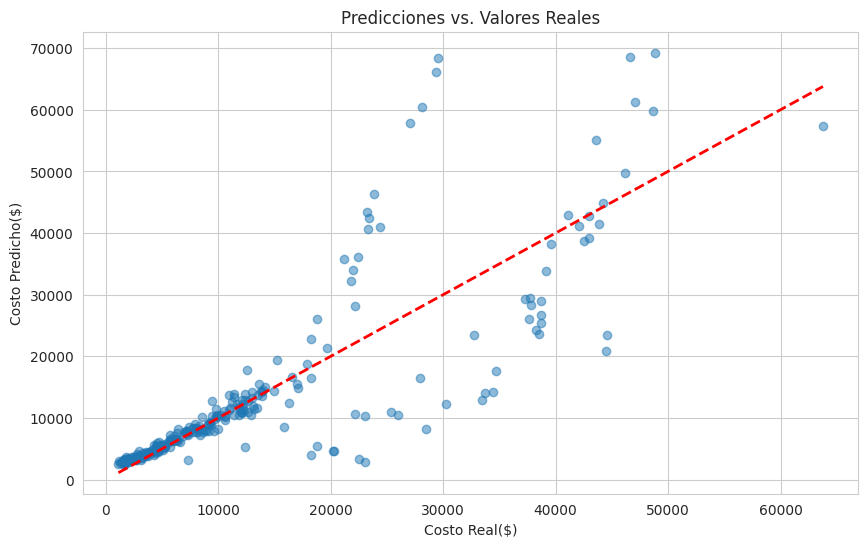

In [19]:
#Vizualizar predicciones vs. reales

plt.figure(figsize=(10,6))
plt.scatter(y_test_orig, y_pred, alpha=0.5)
plt.plot(
    [y_test_orig.min(), y_test_orig.max()],
    [y_test_orig.min(), y_test_orig.max()],
    'r--',
    lw=2
)
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Costo Real($)')
plt.ylabel('Costo Predicho($)')
plt.show()

Esta grafica confirma visualmente lo que el RMSE dice, la mayoria de puntos son predicicones buenas los cuales son los puntos de costos bajos, pero hay ciertos puntos (qeu son los mas caros) que estan muy lejos por debajo de la linea roja, estos son los grande errores que inflan al RMSE

Para puntos lejos por debajo de al linea significan que el costo real era alto pero el costo predicho fue bajo, es decir el modelo subestimo el costo.

Para puntos lejos por encima de la linea el modelo sobreestimo el costo